In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau


import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance

def createSequence(data, window=10, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['mmsi']):
        data_temp = data.loc[data.mmsi == traj_id]
        first_lon = data_temp.loc[0, 'lon']
        first_lat = data_temp.loc[0, 'lat']
        end_lon = data_temp.loc[data_temp.shape[0] - 1, 'lon']
        end_lat = data_temp.loc[data_temp.shape[0] - 1, 'lat']

        data_temp = np.array(data_temp.loc[:, ['lon', 'lat', 'sog', 'cog']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label

# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [3]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, GRU, Reshape, Add, Attention, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau
import numpy as np
from tcn import TCN 
def trainModel(train_X, train_Y, test_X, test_Y):
    input_layer = Input(shape=(train_X.shape[1], train_X.shape[2]))
    conv1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
#     conv2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv1)
    lstm1 = LSTM(32, return_sequences=True,activation='tanh')(conv1)
    lstm2 = LSTM(32, return_sequences=True,activation='tanh')(lstm1)
    lstm3 = LSTM(32, return_sequences=False,activation='tanh')(lstm2)

    attention = Attention()([lstm3, lstm3])
    attended_input = Add()([lstm3, attention])

#     biLSTM = Bidirectional(LSTM(108, return_sequences=False, activation='tanh'))(attended_input)
#     gru1_dropout = Dropout(0.1)(gru1)  # Adding Dropout after the first GRU layer
#     gru1 = GRU(489, return_sequences=True,activation='tanh')(attended_input)
#     gru2 = GRU(30, return_sequences=False,activation='tanh')(gru1)
#     dense2 = Dense(dense_neurons2, activation='relu')(bigru1)
    output_layer = Dense(train_Y.shape[1], activation='relu')(attended_input)
    model = Model(inputs=input_layer, outputs=output_layer)
    adam = Adam(learning_rate=0.01)

    model.compile(loss='mse', optimizer=adam, metrics=['acc'])

    # 保存训练过程中的日志
    log = CSVLogger(f"./CNN-LSTM_A_log.csv", separator=",", append=True)

    # 设置自适应学习率调整策略
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)

    # 开始模型训练
    model.fit(train_X, train_Y, epochs=50, batch_size=32, verbose=1, validation_split=0.1, callbacks=[log, reduce])


    # 在测试集上评估模型性能
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))

    # 保存模型
    model.save(f"./CNN-LSTM-_A_model.h5")

    # 打印模型结构和参数统计
    model.summary()

    return model

In [4]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)
train

mmsi     updateDateFormat         lon  \
0   413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:41:01  120.468625   
1   413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:43:01  120.466964   
2   413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:45:01  120.465346   
3   413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:47:01  120.463671   
4   413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:49:01  120.461955   
..                                ...                  ...         ...   
64  413795456_2021-08-31 11:00:04_3_0  2021-08-31 23:33:30  120.458642   
65  413795456_2021-08-31 11:00:04_3_0  2021-08-31 23:35:30  120.461101   
66  413795456_2021-08-31 11:00:04_3_0  2021-08-31 23:37:30  120.463528   
67  413795456_2021-08-31 11:00:04_3_0  2021-08-31 23:39:30  120.465985   
68  413795456_2021-08-31 11:00:04_3_0  2021-08-31 23:41:30  120.468517   

          lat  cog  sog  
0   30.736513  264  1.7  
1   30.736357  258  1.7  
2   30.736038  258  1.8  
3   30.735686  259  1.8  
4   30.735358  261  1.9  
..        ...  ...  ...  
64  30.734851   83  2.6  
65  30.735135   79  2.6  
66  30.735601   79  2.6  
67  30.736075   81  2.7  
68  30.736462   81  2.7  

[141726 rows x 6 columns]

In [5]:
# 计算归一化参数
nor = np.array(train.loc[:, ['lon', 'lat', 'sog', 'cog']])
m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 10
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [6]:
# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)
# model = load_model("./CNN-LSTM-_A_model.h5")


Epoch 1/50


3282/3282 [==============================] - 28s 7ms/step - loss: 0.0068 - acc: 0.8569 - val_loss: 0.0088 - val_acc: 0.8663 - lr: 0.0100
Epoch 2/50
3276/3282 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9027
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
3282/3282 [==============================] - 23s 7ms/step - loss: 0.0034 - acc: 0.9027 - val_loss: 0.0076 - val_acc: 0.8672 - lr: 0.0100
Epoch 3/50
3282/3282 [==============================] - 23s 7ms/step - loss: 0.0025 - acc: 0.9171 - val_loss: 0.0054 - val_acc: 0.8756 - lr: 0.0050
Epoch 4/50
3282/3282 [==============================] - 23s 7ms/step - loss: 0.0024 - acc: 0.9219 - val_loss: 0.0049 - val_acc: 0.8816 - lr: 0.0050
Epoch 5/50
3282/3282 [==============================] - 23s 7ms/step - loss: 0.0021 - acc: 0.9266 - val_loss: 0.0036 - val_acc: 0.8903 - lr: 0.0050
Epoch 6/50
3282/3282 [==============================] - 23s 7ms/step - loss: 0.0020 - acc: 0.9282 - 

3282/3282 [==============================] - 23s 7ms/step - loss: 0.0011 - acc: 0.9580 - val_loss: 0.0015 - val_acc: 0.9490 - lr: 0.0010
Epoch 48/50
3282/3282 [==============================] - 23s 7ms/step - loss: 0.0011 - acc: 0.9579 - val_loss: 0.0014 - val_acc: 0.9480 - lr: 0.0010
Epoch 49/50
3282/3282 [==============================] - 23s 7ms/step - loss: 0.0011 - acc: 0.9572 - val_loss: 0.0016 - val_acc: 0.9501 - lr: 0.0010
Epoch 50/50
394/394 [==============================] - 1s 2ms/step - loss: 0.0014 - acc: 0.9435
Loss : 0.0014185042819008231, Accuracy: 94.34741139411926
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 4)]              0         []                            
                                                                                                  


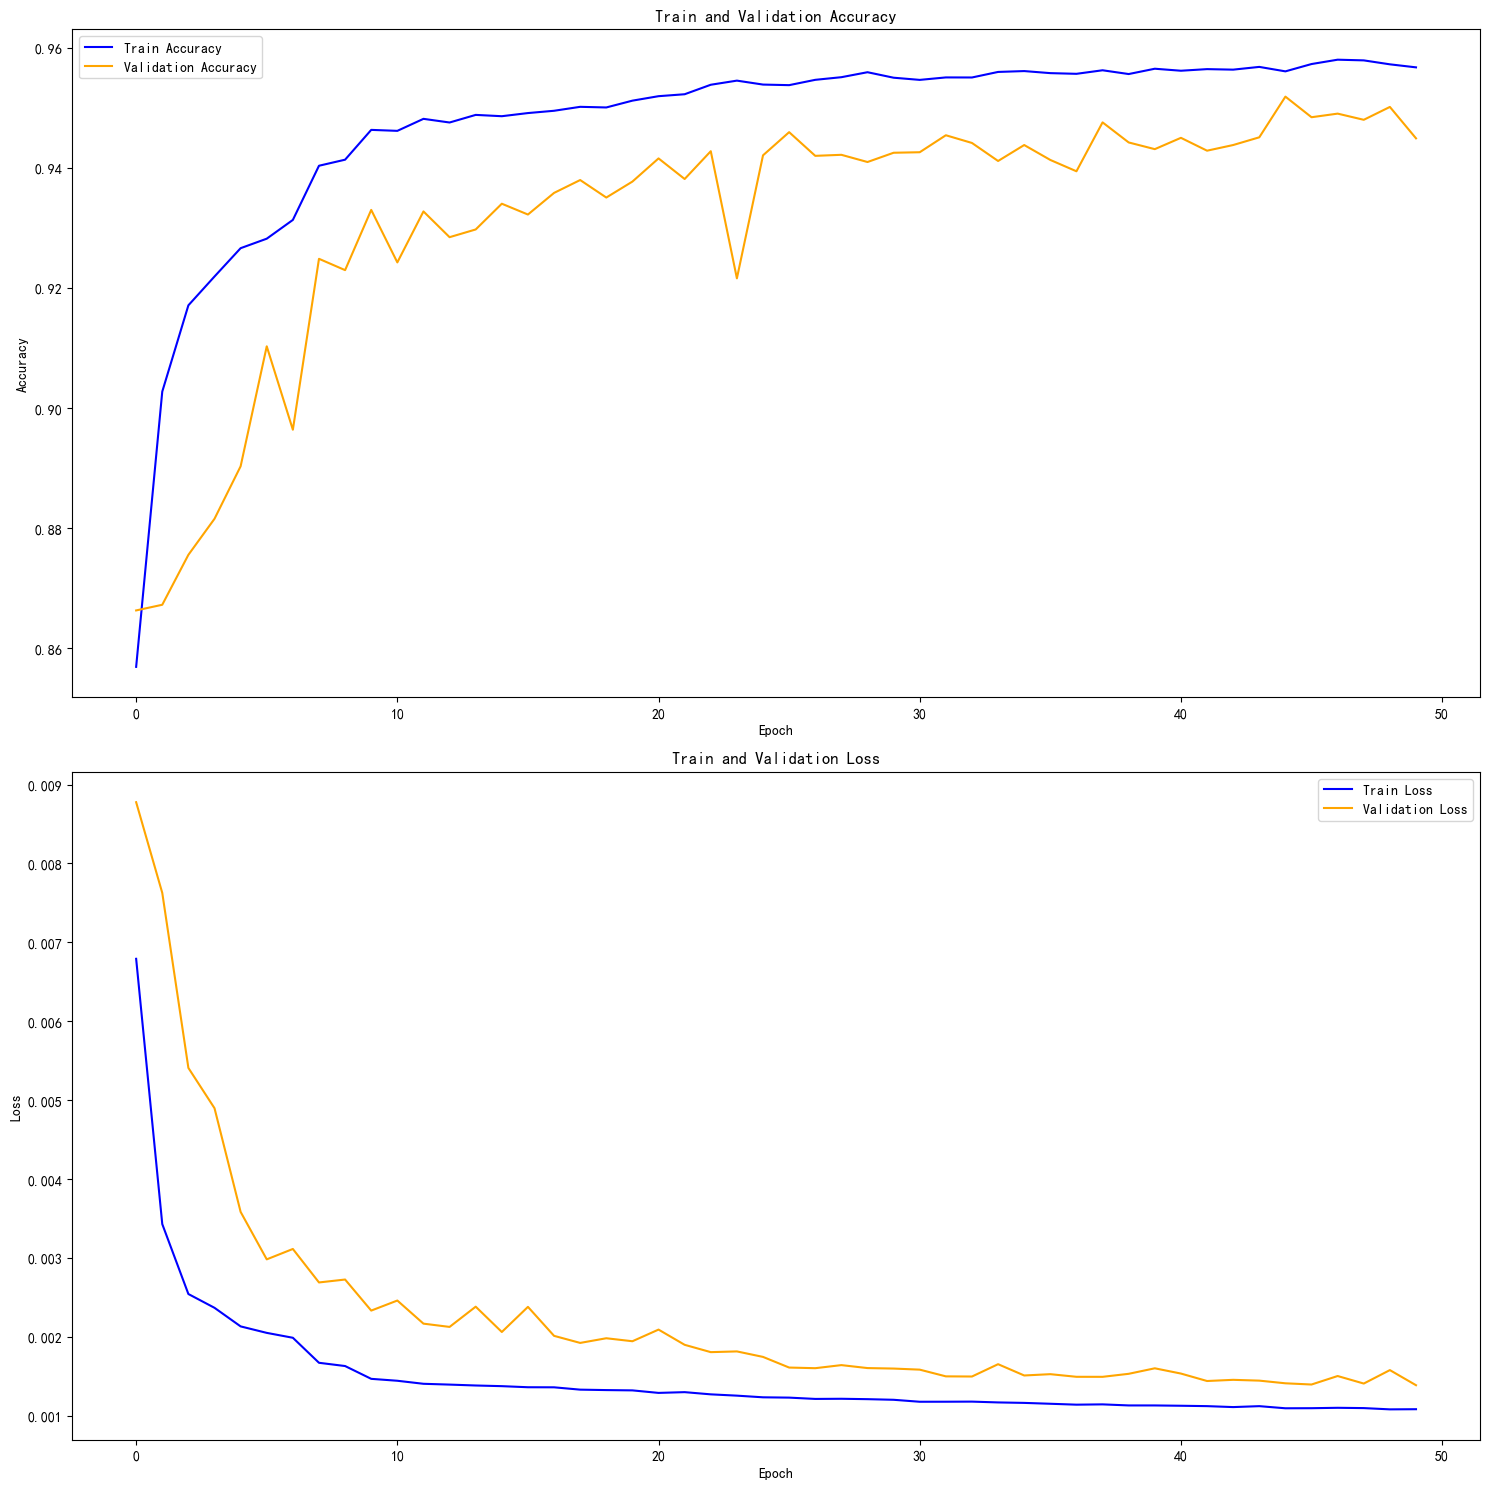

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.read_csv("./CNN-LSTM_A_log.csv")

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Plot accuracy
ax[0].plot(logs['epoch'], logs['acc'], label='Train Accuracy', color='blue')
ax[0].plot(logs['epoch'], logs['val_acc'], label='Validation Accuracy', color='orange')
ax[0].set_title('Train and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(logs['epoch'], logs['loss'], label='Train Loss', color='blue')
ax[1].plot(logs['epoch'], logs['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Train and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [8]:
test_points_ids = list(set(test['mmsi']))
BP_error_list = []
BP_Pre0 = []
BP_Pre1 = []
BP_Pre2 = []
BP_Pre3 = []
BP_Tre0 = []
BP_Tre1 = []
BP_Tre2 = []
BP_Tre3 = []
for ids in test_points_ids:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)
    # 要预测的时间
    pre_time = len(test_seq)
    # 单值预测
    y_pre_BP_50, y_pre_lstm_50, y_pre_GRU_50, y_pre_biLSTM_50, y_pre_bigru_50, y_pre_CNN_RGRU_Attention_50 = [], [], [], [], [], []
    y_true = []

#     for start_id in range(test_seq.shape[0]-int(pre_time)):
    start_id = 0
    pre_seq = test_seq[start_id]
        # 循环预测
    for i in range(int(pre_time)):
        y_hat_BP_50 =model.predict(pre_seq.reshape(1, windows, 4))
            # 其他模型的预测类似...

        y_pre_BP_50.append(y_hat_BP_50[0])
            # 将其他模型的预测结果也添加到相应的列表中...

        y_true.append(test_label[start_id+i])
        # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
        pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_hat_BP_50, axis=0)[1:]
            
    y_pre_BP_50 = np.array(y_pre_BP_50, dtype='float64')
#         y_pre_lstm_50 = np.array(y_pre_lstm_50, dtype='float64')
#         y_pre_GRU_50 = np.array(y_pre_GRU_50, dtype='float64')
#         y_pre_biLSTM_50 = np.array(y_pre_biLSTM_50, dtype='float64')
#         y_pre_bigru_50 = np.array(y_pre_bigru_50, dtype='float64')
#         y_pre_CNN_RGRU_Attention_50 = np.array(y_pre_CNN_RGRU_Attention_50, dtype='float64')

    y_true = np.array(y_true, dtype='float64')
        # 对预测结果进行归一化处理
    f_y_pre_BP_50, f_y_true = FNormalizeMult(y_pre_BP_50, y_true, maxmin)
        # 对其他模型的预测结果也进行相同的处理
#         f_y_pre_lstm_50, f_y_true = FNormalizeMult(y_pre_lstm_50, y_true, maxmin)
#         f_y_pre_GRU_50, f_y_true = FNormalizeMult(y_pre_GRU_50, y_true, maxmin)
#         f_y_pre_biLSTM_50, f_y_true = FNormalizeMult(y_pre_biLSTM_50, y_true, maxmin)
#         f_y_pre_bigru_50, f_y_true = FNormalizeMult(y_pre_bigru_50, y_true, maxmin)
#         f_y_pre_CNN_RGRU_Attention_50, f_y_true = FNormalizeMult(y_pre_CNN_RGRU_Attention_50, y_true, maxmin)


    BP_Pre0.append(list(np.array(f_y_pre_BP_50)[:, 0]))
    BP_Pre1.append(list(np.array(f_y_pre_BP_50)[:, 1]))
    BP_Pre2.append(list(np.array(f_y_pre_BP_50)[:, 2]))
    BP_Pre3.append(list(np.array(f_y_pre_BP_50)[:, 3]))
    BP_Tre0.append(list(np.array(f_y_true)[:, 0]))
    BP_Tre1.append(list(np.array(f_y_true)[:, 1]))
    BP_Tre2.append(list(np.array(f_y_true)[:, 2]))
    BP_Tre3.append(list(np.array(f_y_true)[:, 3]))
    # 将结果添加到错误列表中
#     BP_error_list.append(list(np.array(y_pre_BP_50)[:, 4]))
    # 将其他模型的结果也添加到相应的列表中...




1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


In [9]:
BPP0_data = [item for sublist in BP_Pre0 for item in sublist]
# print(BPP0_data)
BPP1_data = [item for sublist in BP_Pre1 for item in sublist]
# print(BPP1_data)
BPP2_data = [item for sublist in BP_Pre2 for item in sublist]
# print(BPP2_data)
BPP3_data = [item for sublist in BP_Pre3 for item in sublist]
# print(BPP3_data)
BPT0_data = [item for sublist in BP_Tre0 for item in sublist]
# print(BPT0_data)
BPT1_data = [item for sublist in BP_Tre1 for item in sublist]
# print(BPT1_data)
BPT2_data = [item for sublist in BP_Tre2 for item in sublist]
# print(BPT2_data)
BPT3_data = [item for sublist in BP_Tre3 for item in sublist]
# print(BPT3_data)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(BPT0_data, BPP0_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT0_data, BPP0_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT0_data, BPP0_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT1_data, BPP1_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT1_data, BPP1_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT1_data, BPP1_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT2_data, BPP2_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT2_data, BPP2_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT2_data, BPP2_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT3_data, BPP3_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT3_data, BPP3_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT3_data, BPP3_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")

平均绝对误差（MAE）: 0.02047537487103433
均方根误差（MSE）: 0.0009243485416286261
均方根误差（RMSE）: 0.03040310085548226
R2分数（R2_score）: -1.4531071434381806
--------------------------------------------------
平均绝对误差（MAE）: 0.01635772902249437
均方根误差（MSE）: 0.0006369330994384652
均方根误差（RMSE）: 0.025237533545068646
R2分数（R2_score）: -0.4772144089792938
--------------------------------------------------
平均绝对误差（MAE）: 1.5593058533786723
均方根误差（MSE）: 4.605336415232132
均方根误差（RMSE）: 2.1460047565725784
R2分数（R2_score）: -8.909214069240138
--------------------------------------------------
平均绝对误差（MAE）: 65.37809993414916
均方根误差（MSE）: 11583.719939651102
均方根误差（RMSE）: 107.62769132361385
R2分数（R2_score）: -0.0760338699521872
--------------------------------------------------


In [10]:
import numpy as np


# 使用zip将两个列表按照序列顺序组合
combined = list(zip(BPP0_data, BPP1_data, BPP2_data, BPP3_data))

# 转换为numpy数组
CNN_LSTM_Pre = np.array(combined)

print(CNN_LSTM_Pre)
np.savetxt('TCM_BiLSTM_Pre.csv', CNN_LSTM_Pre, delimiter=',')

[[120.44128933  30.72663474   3.25769339 256.67394918]
 [120.43903214  30.72525175   3.10538099 229.63787609]
 [120.43611053  30.7223256    3.0880299  244.23572332]
 ...
 [120.40024234  30.73938747   4.88717    165.81331459]
 [120.41127002  30.7443569    8.74391298 155.98113796]
 [120.41193533  30.73544508   8.02859817 204.69874942]]


In [11]:
import numpy as np


# 使用zip将两个列表按照序列顺序组合
combined_T = list(zip(BPT0_data, BPT1_data, BPT2_data, BPT3_data))

# 转换为numpy数组
CNN_LSTM_Tre = np.array(combined_T)

print(CNN_LSTM_Tre)
np.savetxt('TCN_BiLSTM_Tre.csv', CNN_LSTM_Tre, delimiter=',')

[[120.43827337  30.72677609   3.4        250.        ]
 [120.43526455  30.72572492   3.3        220.        ]
 [120.43335787  30.72347596   3.4        242.        ]
 ...
 [120.46328071  30.7355974    2.7         78.        ]
 [120.46584915  30.7360994    2.8         81.        ]
 [120.46852679  30.7365069    2.8         81.        ]]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# 示例数据



# 计算每个轨迹点的误差
# errors = (tre_array - pre_array).astype(float)

CNN_LSTM_data_P = pd.read_csv('CNN_LSTM_A_Pre.csv')
CNN_LSTM_data_T = pd.read_csv('CNN_LSTM_A_Tre.csv')
CNN_LSTM_lon_tre_array = CNN_LSTM_data_P['lon']
CNN_LSTM_lon_pre_array = CNN_LSTM_data_T['lon']

CNN_LSTM_lon_errors = (CNN_LSTM_lon_tre_array - CNN_LSTM_lon_pre_array).astype(float)

CNN_RGRU_A_data_P = pd.read_csv('CNN_RGRU_A_BEST_Tre.csv')
CNN_RGRU_A_data_T = pd.read_csv('CNN_RGRU_A_BEST_Pre.csv')
CNN_RGRU_A_lon_tre_array = CNN_RGRU_A_data_P['lon']
CNN_RGRU_A_lon_pre_array = CNN_RGRU_A_data_T['lon']


CNN_RGRU_A_lon_errors = (CNN_RGRU_A_lon_tre_array - CNN_RGRU_A_lon_pre_array).astype(float)

CNN_LSTM_data_P = pd.read_csv('CNN_LSTM_A_Pre.csv')
CNN_LSTM_data_T = pd.read_csv('CNN_LSTM_A_Tre.csv')
CNN_LSTM_lat_tre_array = CNN_LSTM_data_P['lat']
CNN_LSTM_lat_pre_array = CNN_LSTM_data_T['lat']

CNN_LSTM_lat_errors = (CNN_LSTM_lat_tre_array - CNN_LSTM_lat_pre_array).astype(float)

CNN_RGRU_A_data_P = pd.read_csv('CNN_RGRU_A_BEST_Tre.csv')
CNN_RGRU_A_data_T = pd.read_csv('CNN_RGRU_A_BEST_Pre.csv')
CNN_RGRU_A_lat_tre_array = CNN_RGRU_A_data_P['lat']
CNN_RGRU_A_lat_pre_array = CNN_RGRU_A_data_T['lat']

CNN_RGRU_A_lat_errors = (CNN_RGRU_A_lat_tre_array - CNN_RGRU_A_lat_pre_array).astype(float)


# 设置图形大小
plt.figure(figsize=(8, 6))

# 绘制散点图，调整点的大小为5
plt.scatter(range(len(CNN_LSTM_lon_errors)), CNN_LSTM_lon_errors, label='CNN-LSTM-Attention_lon', color='blue', s=2)
plt.scatter(range(len(CNN_RGRU_A_lon_errors)), CNN_RGRU_A_lon_errors, label='CNN-RGRU-Attention_lon', color='red', s=2)
plt.scatter(range(len(CNN_LSTM_lat_errors)), CNN_LSTM_lat_errors, label='CNN-LSTM-Attention_lat', color='green', s=2)
plt.scatter(range(len(CNN_RGRU_A_lat_errors)), CNN_RGRU_A_lat_errors, label='CNN-RGRU-Attention_lat', color='black', s=2)
# 添加标签和标题
plt.xlabel('Sequence number')
plt.ylabel('Longitude error and latitude error')
plt.title('Error for Each Trajectory Point in the Sequence')

# 设置横坐标和纵坐标范围
plt.xlim(-1, len(CNN_LSTM_lon_errors))
plt.ylim(-0.1,0.1)

# 显示图形c
plt.legend()
plt.grid(True)
plt.savefig('CNN-LSTM-Attention-C-RG-A_all.png')
plt.show()
# plt.savefig('BIGRU-C-RG-A.png')


FileNotFoundError: [Errno 2] No such file or directory: 'CNN_LSTM_A_Pre.csv'